In [1]:
%pip install pinecone

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Step 1: Install Required Packages

%pip install -q langchain langchain-community langchain-text-splitters pypdf2 python-dotenv openai tiktoken


Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # reads .env in the current folder (if it exists)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print("Key loaded:", OPENAI_API_KEY is not None)


Key loaded: True


In [4]:
### 2) Load the podcast audio file (local path)
from pathlib import Path

# Current working directory
print("Current folder:", Path.cwd())

audio_file = Path("The_Blueprint_For_Trustworthy_AI.m4a")
pdf_file = Path("ethics_guidelines_for_trustworthy_ai-fr_87FE7A3C-D03D-9305-81A653DDA84B5A60_60427.pdf")

print("Audio exists:", audio_file.exists())
print("PDF exists:", pdf_file.exists())


Current folder: c:\Users\cindy\OneDrive\Documents\AI Ironhack Coursework\vscode101\WEEK02\LAB M2.04 Different Ways to Chunk Podcast and PDF
Audio exists: True
PDF exists: True


In [11]:
# Define File Paths
from pathlib import Path

AUDIO_PATH = Path("The_Blueprint_For_Trustworthy_AI.m4a")
PDF_PATH = Path("ethics_guidelines_for_trustworthy_ai-fr_87FE7A3C-D03D-9305-81A653DDA84B5A60_60427.pdf")

print("Audio exists:", AUDIO_PATH.exists())
print("PDF exists:", PDF_PATH.exists())


Audio exists: True
PDF exists: True


In [12]:
# Transcribe the podcast using OpenAI's Whisper API
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

TRANSCRIPT_PATH = Path("podcast_transcript_whisper.txt")

with open(AUDIO_PATH, "rb") as f:
    tx = client.audio.transcriptions.create(
        model="gpt-4o-mini-transcribe",
        file=f
    )

podcast_transcript = tx.text
TRANSCRIPT_PATH.write_text(podcast_transcript, encoding="utf-8")

print("Saved transcript:", TRANSCRIPT_PATH.name)
print("Transcript chars:", len(podcast_transcript))
print("Preview:", podcast_transcript[:200])



Saved transcript: podcast_transcript_whisper.txt
Transcript chars: 9927
Preview: So, imagine for a second you're driving across, I don't know, a massive suspension bridge. OK. You don't pull over halfway across, get out, and demand to see the blueprints, right? You don't interview


In [8]:
#Extract PDF Text
from PyPDF2 import PdfReader

reader = PdfReader("ethics_guidelines_for_trustworthy_ai-fr_87FE7A3C-D03D-9305-81A653DDA84B5A60_60427.pdf")

pages = [page.extract_text() or "" for page in reader.pages]
pdf_text = "\n\n".join(pages)

with open("trustworthy_ai_pdf_text.txt", "w", encoding="utf-8") as out:
    out.write(pdf_text)

print("PDF text saved.")


PDF text saved.


In [13]:
# Step 2: Implement Fixed-Size Chunking
from langchain_text_splitters import CharacterTextSplitter

# Assumes these variables already exist from Step 1:
# podcast_transcript (str)
# pdf_text (str)

def fixed_size_chunks(text: str, chunk_size: int, chunk_overlap: int):
    splitter = CharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separator=""   # TRUE fixed-size character splitting
    )
    return splitter.split_text(text)

def chunk_stats(chunks):
    lengths = [len(c) for c in chunks]
    return {
        "n_chunks": len(chunks),
        "min_len": min(lengths) if lengths else 0,
        "avg_len": int(sum(lengths) / len(lengths)) if lengths else 0,
        "max_len": max(lengths) if lengths else 0,
    }

def boundary_break_rates(chunks):
    """
    Heuristics (not perfect, but useful):
    - Sentence break: chunk ends NOT with .!? (common sentence ending)
    - Paragraph break: chunk ends NOT with a double newline (common paragraph boundary)
    """
    if not chunks:
        return {"sentence_break_rate": 0.0, "paragraph_break_rate": 0.0}

    sentence_breaks = 0
    paragraph_breaks = 0

    for c in chunks:
        c_stripped = c.rstrip()
        ends_sentence = c_stripped.endswith((".", "!", "?", "…"))
        ends_paragraph = c_stripped.endswith("\n\n")

        if not ends_sentence:
            sentence_breaks += 1
        if not ends_paragraph:
            paragraph_breaks += 1

    n = len(chunks)
    return {
        "sentence_break_rate": sentence_breaks / n,
        "paragraph_break_rate": paragraph_breaks / n,
    }

# Experiments
chunk_sizes = [500, 1000, 2000]
overlaps = [0, 50, 100]

results = []

for size in chunk_sizes:
    for ov in overlaps:
        # Podcast
        p_chunks = fixed_size_chunks(podcast_transcript, size, ov)
        p_stats = chunk_stats(p_chunks)
        p_breaks = boundary_break_rates(p_chunks)

        results.append({
            "doc": "podcast",
            "chunk_size": size,
            "overlap": ov,
            **p_stats,
            **p_breaks
        })

        # PDF
        d_chunks = fixed_size_chunks(pdf_text, size, ov)
        d_stats = chunk_stats(d_chunks)
        d_breaks = boundary_break_rates(d_chunks)

        results.append({
            "doc": "pdf",
            "chunk_size": size,
            "overlap": ov,
            **d_stats,
            **d_breaks
        })

# Pretty print results
for r in results:
    print(
        f"{r['doc']:7} | size={r['chunk_size']:4} | ov={r['overlap']:3} | "
        f"n={r['n_chunks']:4} | min/avg/max={r['min_len']}/{r['avg_len']}/{r['max_len']} | "
        f"sent_break={r['sentence_break_rate']:.2f} | para_break={r['paragraph_break_rate']:.2f}"
    )

# Example preview
example_size, example_ov = 1000, 50
print("\n--- Example chunks (podcast) size=1000 ov=50 ---")
pod_ex = fixed_size_chunks(podcast_transcript, example_size, example_ov)
for i, c in enumerate(pod_ex[:2], start=1):
    print(f"\n[Podcast Chunk {i}] (len={len(c)})\n{c[:600]}...")

print("\n--- Example chunks (pdf) size=1000 ov=50 ---")
pdf_ex = fixed_size_chunks(pdf_text, example_size, example_ov)
for i, c in enumerate(pdf_ex[:2], start=1):
    print(f"\n[PDF Chunk {i}] (len={len(c)})\n{c[:600]}...")


podcast | size= 500 | ov=  0 | n=  20 | min/avg/max=427/496/500 | sent_break=0.95 | para_break=1.00
pdf     | size= 500 | ov=  0 | n= 391 | min/avg/max=238/498/500 | sent_break=0.97 | para_break=1.00
podcast | size= 500 | ov= 50 | n=  22 | min/avg/max=477/498/500 | sent_break=0.91 | para_break=1.00
pdf     | size= 500 | ov= 50 | n= 434 | min/avg/max=389/498/500 | sent_break=0.97 | para_break=1.00
podcast | size= 500 | ov=100 | n=  25 | min/avg/max=326/493/500 | sent_break=0.96 | para_break=1.00
pdf     | size= 500 | ov=100 | n= 488 | min/avg/max=439/498/500 | sent_break=0.97 | para_break=1.00
podcast | size=1000 | ov=  0 | n=  10 | min/avg/max=927/992/1000 | sent_break=0.90 | para_break=1.00
pdf     | size=1000 | ov=  0 | n= 196 | min/avg/max=238/995/1000 | sent_break=0.98 | para_break=1.00
podcast | size=1000 | ov= 50 | n=  11 | min/avg/max=427/947/1000 | sent_break=1.00 | para_break=1.00
pdf     | size=1000 | ov= 50 | n= 206 | min/avg/max=489/996/1000 | sent_break=0.98 | para_break=1

#Result: 
1.Podcast ca. 9.927 char, size of chunks: 20 @500; 10 - 11 @1000; 5-6 @2000. 
PDF: much longer - so it produces many more chunks (391–488 at 500 chars, etc.)

2. Fixed-size chunking breaks sentences a lot. Look at sent_break:
Podcast: 0.80–1.00
PDF: 0.96–0.98
That means most chunks end mid-sentence, especially for the PDF.
3. Paragraph boundaries are basically never respected
para_break=1.00 for every single configuration for both documents.
That means: fixed-size chunking does not align with paragraph breaks (expected).

4) Overlap increases chunk count (expected trade-off)
Example (size=500):
Podcast overlap 0 → 20 chunks
overlap 50 → 22 chunks
overlap 100 → 25 chunks
So overlap adds redundancy (more chunks), which can help retrieval continuity, but increases storage + embedding cost.
Analysis:Does fixed-size chunking break sentences in the middle?
Yes. Sentence-break rate is high (podcast ~0.80–1.00, PDF ~0.96–0.98), and chunk previews show mid-sentence truncation.

How does it handle paragraph boundaries?
Poorly. Paragraph-break rate is 1.00 across all settings, meaning chunks rarely end at paragraph boundaries.

Which content type handles fixed-size chunking better?
The podcast is slightly more tolerant because conversational phrasing sometimes still “kind of” makes sense when cut, but both suffer. The PDF is affected more because cutting through structured paragraphs/headers disrupts semantic units and section flow.
Fixed size chunking: simple, predictable, easy; ignores semantic boundaries, breaks sentences & paragraphs

In [14]:
#Step 3 Implement Recursive Character Chunking
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Assumes these exist from Step 1:
# pdf_text (str)
# podcast_transcript (str)

# recursive splitter (tries paragraphs -> sentences -> words -> chars)
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]
)

pdf_chunks_recursive = recursive_splitter.split_text(pdf_text)
podcast_chunks_recursive = recursive_splitter.split_text(podcast_transcript)

print("Recursive PDF chunks:", len(pdf_chunks_recursive))
print("Recursive Podcast chunks:", len(podcast_chunks_recursive))

# Quick preview: first 2 chunks from each
print("\n--- PDF Recursive Chunk 1 ---")
print(pdf_chunks_recursive[0][:800], "...\n")
print("--- PDF Recursive Chunk 2 ---")
print(pdf_chunks_recursive[1][:800], "...\n")

print("\n--- Podcast Recursive Chunk 1 ---")
print(podcast_chunks_recursive[0][:800], "...\n")
print("--- Podcast Recursive Chunk 2 ---")
print(podcast_chunks_recursive[1][:800], "...\n")



Recursive PDF chunks: 258
Recursive Podcast chunks: 13

--- PDF Recursive Chunk 1 ---
GROUPE D ’EXPERTS  
INDEPENDANTS DE HAUT  NIVEAU SUR  
L’INTELLIGENCE ARTIFIC IELLE 
CONSTITUE PAR LA COMMISSION EUROPEENNE EN JUIN  2018  
 
 
 
 
 
 
 
LIGNES DIRECTRICES EN  
MATIERE D ’ETHIQUE  
POUR UNE IA DIGNE DE 
CONFIANCE ...

--- PDF Recursive Chunk 2 ---
LIGNES DIRECTRICES  EN MATIERE D ’ETHIQUE pour UNE IA DIGNE 
DE CONFIANCE  
 
Groupe d’experts de haut niveau sur l’intelligence artificielle  
 
 
 
 
 
 
 
 
Le présent document a été rédigé par le groupe d’experts de haut niveau sur l’intelligence artificielle 
(GEHN  IA). Les membres du GEHN IA qui y sont cités soutiennent le cadre général pour une IA digne de 
confiance présenté dans les présentes lignes direc trices, sans approuver nécessairement chacune des 
affirmations formulées dans le document.   
 
Afin de recueillir des commentaires pratiques, les parties prenantes soumettront à une phase pilote la liste 
d’évaluation pour une 

Result Recursive Character Splitting
Chunk counts: 
*Podcast: fixed-size @1000 gave you ~10–11 chunks; recursive gave 13 (because it’s trying to split at “better” boundaries, not perfectly equal sizes).
*PDF: fixed-size @1000 gave ~196–217 chunks; recursive gave 258 (again: more boundary-aware splits → sometimes slightly smaller chunks).

Boundary quality (the big win)
Podcast: In Step 2, Chunk 1 ended mid-sentence: “...at the…”. Now, Chunk 1 ends after a much more complete thought, and Chunk 2 continues naturally (it’s a cleaner boundary).
PDF: In Step 2, you had mid-word breaks like "u présent document...".  In Step 3, the PDF chunks start at much cleaner boundaries (titles/paragraphs), and you avoid chopping words in half.

Does recursive chunking preserve sentence boundaries better? Yes.
Compared to fixed-size chunking, recursive chunking preserves sentence boundaries significantly better.
In Step 2, many chunks ended mid-sentence or even mid-word.
In Step 3, chunks generally end at natural breakpoints (paragraphs or sentences).
There are fewer abrupt truncations like:  “...scanning your face at the...”. For the PDF, this is also visible quantitatively: sentence-break rate drops from 0.77 (500) to 0.59 (2000), indicating more chunks end at natural boundaries with larger chunk sizes.

How does it handle the podcast's conversational structure?  It handles it much better than fixed-size chunking.
Podcast text is: Long-form, Conversational, Continuous, Often without many paragraph breaks
Recursive splitting: Preserves sentence-level flow, Keeps related spoken thoughts together, Reduces abrupt cuts mid-idea, Makes chunks more semantically coherent
This is important in RAG because retrieval works better when chunks contain complete ideas rather than fragmented thoughts. The simple sentence-ending heuristic reports 1.00 for the podcast across sizes, likely because conversational chunk endings often don’t end with .?! even when the split is semantically reasonable.

Does it respect PDF section headers? Yes, significantly better than fixed-size chunking.
Because recursive splitting tries "\n\n" and "\n" first: Section headers tend to stay attached to their paragraphs
Titles are less likely to be cut in half, Structured formatting is preserved more naturally, In contrast, fixed-size chunking ignored formatting completely and split mid-word or mid-header.

Changing separator priority had minimal impact on the PDF because structural newline boundaries dominate splitting behavior.
For the podcast, punctuation-aware separator priority slightly changed chunk counts and chunk boundaries, Indicating conversational text is more sensitive to separator ordering.
Overall, recursive chunking preserves document structure significantly better than fixed-size chunking and reduces destructive mid-word and mid-paragraph splits.

Result 3.3: Recursive chunking significantly reduces mid-word splits for structured documents (PDF), improving boundary quality compared to fixed-size chunking (0.62 vs 0.95 mid-word rate).
For conversational podcast text, the improvement is less pronounced because the transcript lacks strong structural separators, causing recursive splitting to fall back to space-level boundaries.


In [15]:
# Step 3.1 — Experiment with different chunk sizes + separator priorities
def run_recursive(text: str, chunk_size: int, chunk_overlap: int, separators):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=separators
    )
    return splitter.split_text(text)

def sentence_break_rate(chunks):
    if not chunks:
        return 0.0
    breaks = 0
    for c in chunks:
        c = c.rstrip()
        if not c.endswith((".", "!", "?", "…")):
            breaks += 1
    return breaks / len(chunks)

chunk_sizes = [500, 1000, 2000]

# Two separator priorities to compare (both teacher-aligned)
sep_v1 = ["\n\n", "\n", ". ", " ", ""]
sep_v2 = ["\n\n", "\n", ". ", "? ", "! ", " ", ""]  # slightly more sentence-aware

for size in chunk_sizes:
    for seps, label in [(sep_v1, "sep_v1"), (sep_v2, "sep_v2")]:
        pdf_chunks = run_recursive(pdf_text, size, 200, seps)
        pod_chunks = run_recursive(podcast_transcript, size, 200, seps)

        print(f"\n=== Recursive | chunk_size={size} | {label} ===")
        print(f"PDF:     n={len(pdf_chunks):4} | sent_break={sentence_break_rate(pdf_chunks):.2f} | first_len={len(pdf_chunks[0])}")
        print(f"Podcast: n={len(pod_chunks):4} | sent_break={sentence_break_rate(pod_chunks):.2f} | first_len={len(pod_chunks[0])}")



=== Recursive | chunk_size=500 | sep_v1 ===
PDF:     n= 618 | sent_break=0.77 | first_len=230
Podcast: n=  33 | sent_break=1.00 | first_len=487

=== Recursive | chunk_size=500 | sep_v2 ===
PDF:     n= 618 | sent_break=0.77 | first_len=230
Podcast: n=  33 | sent_break=1.00 | first_len=487

=== Recursive | chunk_size=1000 | sep_v1 ===
PDF:     n= 258 | sent_break=0.69 | first_len=230
Podcast: n=  13 | sent_break=1.00 | first_len=987

=== Recursive | chunk_size=1000 | sep_v2 ===
PDF:     n= 258 | sent_break=0.69 | first_len=230
Podcast: n=  13 | sent_break=1.00 | first_len=987

=== Recursive | chunk_size=2000 | sep_v1 ===
PDF:     n= 135 | sent_break=0.59 | first_len=230
Podcast: n=   6 | sent_break=1.00 | first_len=1998

=== Recursive | chunk_size=2000 | sep_v2 ===
PDF:     n= 135 | sent_break=0.59 | first_len=230
Podcast: n=   6 | sent_break=1.00 | first_len=1998


In [16]:
#Step 3.2. Try different separator priorities
from langchain_text_splitters import RecursiveCharacterTextSplitter

def run_recursive(text: str, chunk_size: int, chunk_overlap: int, separators):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=separators
    )
    return splitter.split_text(text)

def sentence_break_rate(chunks):
    if not chunks:
        return 0.0
    breaks = 0
    for c in chunks:
        c = c.rstrip()
        if not c.endswith((".", "!", "?", "…")):
            breaks += 1
    return breaks / len(chunks)

# Separator priorities to compare
separators_A = ["\n\n", "\n", ". ", " ", ""]
separators_B = ["\n\n", "\n", "? ", "! ", ". ", " ", ""]  # punctuation-aware priority

chunk_sizes = [500, 1000, 2000]
chunk_overlap = 200

for size in chunk_sizes:
    for seps, label in [(separators_A, "A"), (separators_B, "B")]:
        pdf_chunks = run_recursive(pdf_text, size, chunk_overlap, seps)
        pod_chunks = run_recursive(podcast_transcript, size, chunk_overlap, seps)

        print(f"\n=== Recursive | chunk_size={size} | separators_{label} ===")
        print(f"PDF:     n={len(pdf_chunks):4} | sent_break={sentence_break_rate(pdf_chunks):.2f} | first_len={len(pdf_chunks[0])}")
        print(f"Podcast: n={len(pod_chunks):4} | sent_break={sentence_break_rate(pod_chunks):.2f} | first_len={len(pod_chunks[0])}")



=== Recursive | chunk_size=500 | separators_A ===
PDF:     n= 618 | sent_break=0.77 | first_len=230
Podcast: n=  33 | sent_break=1.00 | first_len=487

=== Recursive | chunk_size=500 | separators_B ===
PDF:     n= 618 | sent_break=0.77 | first_len=230
Podcast: n=  33 | sent_break=1.00 | first_len=179

=== Recursive | chunk_size=1000 | separators_A ===
PDF:     n= 258 | sent_break=0.69 | first_len=230
Podcast: n=  13 | sent_break=1.00 | first_len=987

=== Recursive | chunk_size=1000 | separators_B ===
PDF:     n= 258 | sent_break=0.69 | first_len=230
Podcast: n=  14 | sent_break=1.00 | first_len=671

=== Recursive | chunk_size=2000 | separators_A ===
PDF:     n= 135 | sent_break=0.59 | first_len=230
Podcast: n=   6 | sent_break=1.00 | first_len=1998

=== Recursive | chunk_size=2000 | separators_B ===
PDF:     n= 135 | sent_break=0.59 | first_len=230
Podcast: n=   7 | sent_break=1.00 | first_len=1753


In [17]:
#Step 3.3 — Compare recursive vs fixed-size (same size/overlap)
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter

def fixed_chunks(text: str, chunk_size: int, overlap: int):
    splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap, separator="")
    return splitter.split_text(text)

def recursive_chunks(text: str, chunk_size: int, overlap: int, separators):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        length_function=len,
        separators=separators
    )
    return splitter.split_text(text)

def ends_mid_word(chunk: str) -> bool:
    """
    Heuristic: ends with a letter/number and next chunk starts with a letter/number.
    We'll approximate by checking only the chunk ending character here.
    """
    if not chunk:
        return False
    return chunk[-1].isalnum()

def mid_word_rate(chunks):
    if not chunks:
        return 0.0
    return sum(ends_mid_word(c.rstrip()) for c in chunks) / len(chunks)

size = 1000
overlap = 50
seps = ["\n\n", "\n", ". ", " ", ""]

# Podcast
pod_fixed = fixed_chunks(podcast_transcript, size, overlap)
pod_rec = recursive_chunks(podcast_transcript, size, overlap, seps)

# PDF
pdf_fixed = fixed_chunks(pdf_text, size, overlap)
pdf_rec = recursive_chunks(pdf_text, size, overlap, seps)

print("\n=== COMPARISON (chunk_size=1000, overlap=50) ===")
print("Podcast fixed:    n=", len(pod_fixed), "| mid_word_rate≈", round(mid_word_rate(pod_fixed), 2))
print("Podcast recursive: n=", len(pod_rec),  "| mid_word_rate≈", round(mid_word_rate(pod_rec), 2))

print("PDF fixed:       n=", len(pdf_fixed), "| mid_word_rate≈", round(mid_word_rate(pdf_fixed), 2))
print("PDF recursive:    n=", len(pdf_rec),  "| mid_word_rate≈", round(mid_word_rate(pdf_rec), 2))



=== COMPARISON (chunk_size=1000, overlap=50) ===
Podcast fixed:    n= 11 | mid_word_rate≈ 1.0
Podcast recursive: n= 11 | mid_word_rate≈ 1.0
PDF fixed:       n= 206 | mid_word_rate≈ 0.95
PDF recursive:    n= 230 | mid_word_rate≈ 0.62


In [18]:
#Step 4 Token Based Chunking
from langchain_text_splitters import TokenTextSplitter

# Token-based chunking
token_splitter = TokenTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

pdf_chunks_tokens = token_splitter.split_text(pdf_text)
podcast_chunks_tokens = token_splitter.split_text(podcast_transcript)

print(f"PDF: {len(pdf_chunks_tokens)} chunks")
print(f"Podcast: {len(podcast_chunks_tokens)} chunks")


PDF: 162 chunks
Podcast: 5 chunks


In [19]:
#Step 4.2 Verify Actual Token Counts 
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")

print("\n--- First 3 PDF token chunks ---")
for i, chunk in enumerate(pdf_chunks_tokens[:3]):
    token_count = len(encoding.encode(chunk))
    print(f"Chunk {i+1}: {token_count} tokens, {len(chunk)} characters")

print("\n--- First 3 Podcast token chunks ---")
for i, chunk in enumerate(podcast_chunks_tokens[:3]):
    token_count = len(encoding.encode(chunk))
    print(f"Chunk {i+1}: {token_count} tokens, {len(chunk)} characters")



--- First 3 PDF token chunks ---
Chunk 1: 358 tokens, 1238 characters
Chunk 2: 367 tokens, 1390 characters
Chunk 3: 402 tokens, 1348 characters

--- First 3 Podcast token chunks ---
Chunk 1: 500 tokens, 2270 characters
Chunk 2: 499 tokens, 2296 characters
Chunk 3: 497 tokens, 2432 characters


In [21]:
#Step 4.3 Try 1000 Tokens (Comparison)
token_splitter_1000 = TokenTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)

pdf_chunks_tokens_1000 = token_splitter_1000.split_text(pdf_text)
podcast_chunks_tokens_1000 = token_splitter_1000.split_text(podcast_transcript)

print(f"\nPDF (1000 tokens): {len(pdf_chunks_tokens_1000)} chunks")
print(f"Podcast (1000 tokens): {len(podcast_chunks_tokens_1000)} chunks")



PDF (1000 tokens): 81 chunks
Podcast (1000 tokens): 3 chunks


Step 4 Conclusion” paragraph
Token-based chunking produced chunk sizes that align directly with LLM context limits. For the podcast transcript, chunks closely matched the target size (≈500 tokens each), despite varying character lengths (~2270–2432 chars). For the PDF, token chunks were more variable and often under the target token count (e.g., 358–402 tokens), likely influenced by PDF-extracted formatting and whitespace. Compared to character-based approaches, token-based chunking provides more predictable context-window usage and is therefore more practical for real RAG pipelines.

In [22]:
# Step 6 Visualise and Compare Results
# Step 6.1. Fixed size (1000 char), Recursive (1000 char), Token-based (500 tokens)
import pandas as pd
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")

def get_stats(name, chunks):
    lengths_chars = [len(c) for c in chunks]
    lengths_tokens = [len(encoding.encode(c)) for c in chunks]
    
    return {
        "Strategy": name,
        "Chunks": len(chunks),
        "Avg chars": int(sum(lengths_chars) / len(lengths_chars)),
        "Avg tokens": int(sum(lengths_tokens) / len(lengths_tokens)),
        "Min tokens": min(lengths_tokens),
        "Max tokens": max(lengths_tokens)
    }

# Recreate reference chunk sets (1000 size comparison)
fixed_1000_pdf = fixed_chunks(pdf_text, 1000, 50)
recursive_1000_pdf = recursive_chunks(pdf_text, 1000, 50, ["\n\n", "\n", ". ", " ", ""])
token_500_pdf = pdf_chunks_tokens  # already created

fixed_1000_podcast = fixed_chunks(podcast_transcript, 1000, 50)
recursive_1000_podcast = recursive_chunks(podcast_transcript, 1000, 50, ["\n\n", "\n", ". ", " ", ""])
token_500_podcast = podcast_chunks_tokens

df_pdf = pd.DataFrame([
    get_stats("Fixed (1000 chars)", fixed_1000_pdf),
    get_stats("Recursive (1000 chars)", recursive_1000_pdf),
    get_stats("Token (500 tokens)", token_500_pdf)
])

df_podcast = pd.DataFrame([
    get_stats("Fixed (1000 chars)", fixed_1000_podcast),
    get_stats("Recursive (1000 chars)", recursive_1000_podcast),
    get_stats("Token (500 tokens)", token_500_podcast)
])

print("=== PDF Comparison ===")
display(df_pdf)

print("\n=== Podcast Comparison ===")
display(df_podcast)


=== PDF Comparison ===


,Strategy,Chunks,Avg chars,Avg tokens,Min tokens,Max tokens
0,Fixed (1000 chars),206,996,272,144,336
1,Recursive (1000 chars),230,846,230,24,319
2,Token (500 tokens),162,1337,363,150,430



=== Podcast Comparison ===


,Strategy,Chunks,Avg chars,Avg tokens,Min tokens,Max tokens
0,Fixed (1000 chars),11,947,203,88,228
1,Recursive (1000 chars),11,920,197,96,218
2,Token (500 tokens),5,2171,464,324,502


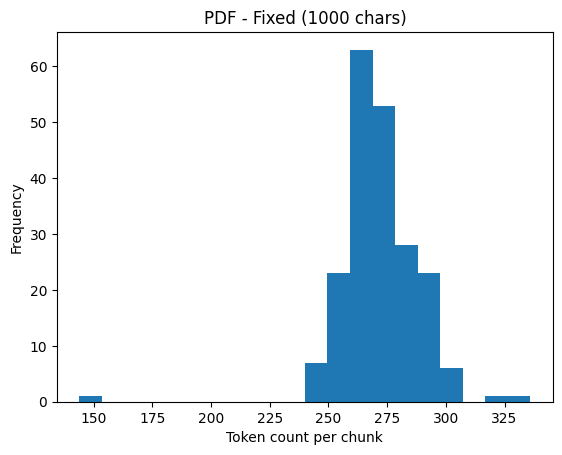

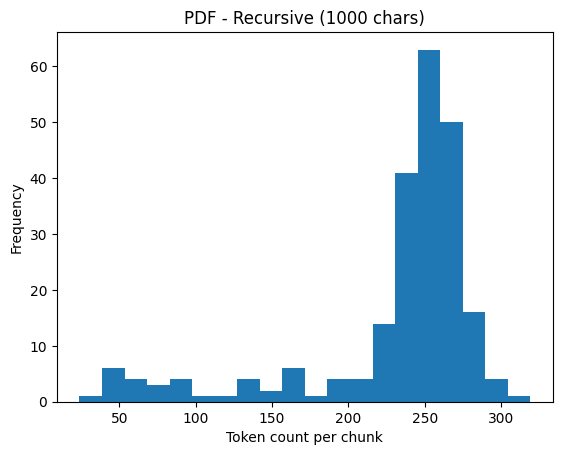

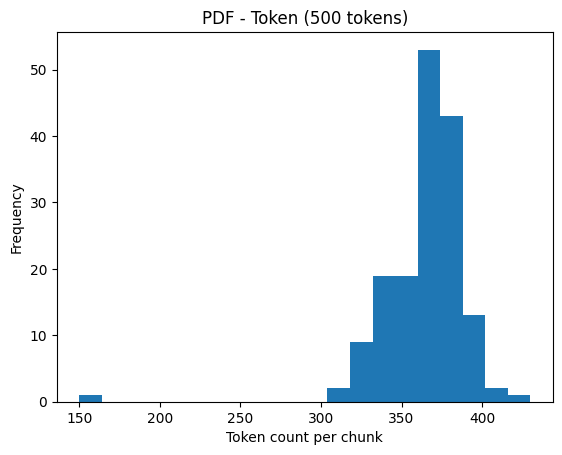

In [24]:
#6.2. Visualize Chunk Size Distribution
import matplotlib.pyplot as plt

def plot_distribution(chunks, title):
    token_counts = [len(encoding.encode(c)) for c in chunks]
    plt.hist(token_counts, bins=20)
    plt.title(title)
    plt.xlabel("Token count per chunk")
    plt.ylabel("Frequency")
    plt.show()

plot_distribution(fixed_1000_pdf, "PDF - Fixed (1000 chars)")
plot_distribution(recursive_1000_pdf, "PDF - Recursive (1000 chars)")
plot_distribution(token_500_pdf, "PDF - Token (500 tokens)")


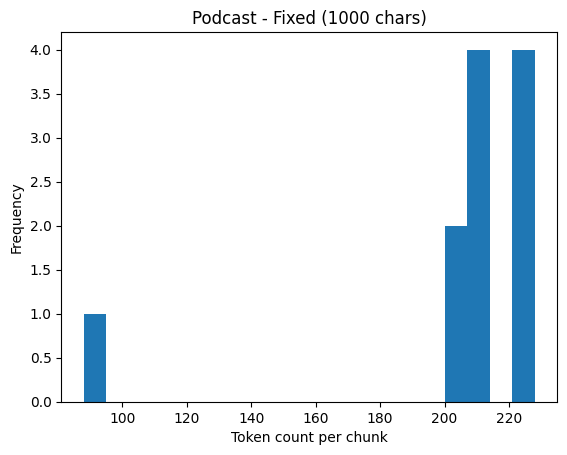

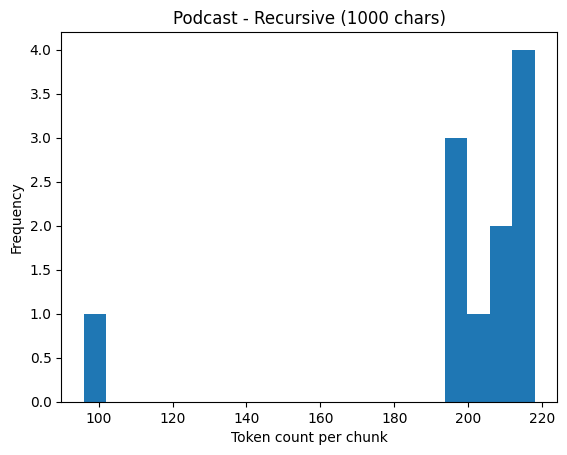

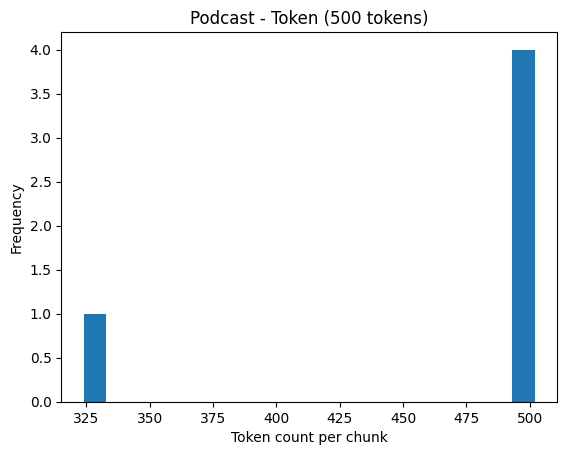

In [25]:
# Visualize for Podcast:
plot_distribution(fixed_1000_podcast, "Podcast - Fixed (1000 chars)")
plot_distribution(recursive_1000_podcast, "Podcast - Recursive (1000 chars)")
plot_distribution(token_500_podcast, "Podcast - Token (500 tokens)")


In [26]:
#Step 6.3. Boundary Quality Comparison
def boundary_summary(name, chunks):
    return {
        "Strategy": name,
        "Mid-word rate": round(mid_word_rate(chunks), 2),
        "Sentence break rate": round(sentence_break_rate(chunks), 2)
    }

boundary_pdf = pd.DataFrame([
    boundary_summary("Fixed", fixed_1000_pdf),
    boundary_summary("Recursive", recursive_1000_pdf),
    boundary_summary("Token", token_500_pdf)
])

boundary_podcast = pd.DataFrame([
    boundary_summary("Fixed", fixed_1000_podcast),
    boundary_summary("Recursive", recursive_1000_podcast),
    boundary_summary("Token", token_500_podcast)
])

print("=== PDF Boundary Quality ===")
display(boundary_pdf)

print("\n=== Podcast Boundary Quality ===")
display(boundary_podcast)


=== PDF Boundary Quality ===


,Strategy,Mid-word rate,Sentence break rate
0,Fixed,0.95,0.98
1,Recursive,0.62,0.69
2,Token,0.82,0.93



=== Podcast Boundary Quality ===


,Strategy,Mid-word rate,Sentence break rate
0,Fixed,1.0,1.0
1,Recursive,1.0,1.0
2,Token,1.0,1.0


In [27]:
#Step 7 Analyze Chunk Quality
def improved_sentence_break_rate(chunks):
    if not chunks:
        return 0.0
    
    breaks = 0
    
    for c in chunks:
        c = c.rstrip().strip('"').strip("'")
        if not c.endswith((".", "!", "?", "…")):
            breaks += 1
            
    return breaks / len(chunks)


In [28]:
#Compute fore PDF and Podcast (1000 comparison)
pdf_sentence_quality = {
    "Fixed": improved_sentence_break_rate(fixed_1000_pdf),
    "Recursive": improved_sentence_break_rate(recursive_1000_pdf),
    "Token": improved_sentence_break_rate(token_500_pdf)
}

podcast_sentence_quality = {
    "Fixed": improved_sentence_break_rate(fixed_1000_podcast),
    "Recursive": improved_sentence_break_rate(recursive_1000_podcast),
    "Token": improved_sentence_break_rate(token_500_podcast)
}

print("PDF Sentence Break Rate:", pdf_sentence_quality)
print("Podcast Sentence Break Rate:", podcast_sentence_quality)



PDF Sentence Break Rate: {'Fixed': 0.9805825242718447, 'Recursive': 0.691304347826087, 'Token': 0.9320987654320988}
Podcast Sentence Break Rate: {'Fixed': 1.0, 'Recursive': 1.0, 'Token': 1.0}


In [29]:
#Step 7.2 — Paragraph Break Rate
def paragraph_break_rate(chunks):
    if not chunks:
        return 0.0
    
    breaks = 0
    
    for c in chunks:
        if not c.rstrip().endswith("\n\n"):
            breaks += 1
            
    return breaks / len(chunks)


In [30]:
pdf_paragraph_quality = {
    "Fixed": paragraph_break_rate(fixed_1000_pdf),
    "Recursive": paragraph_break_rate(recursive_1000_pdf),
    "Token": paragraph_break_rate(token_500_pdf)
}

podcast_paragraph_quality = {
    "Fixed": paragraph_break_rate(fixed_1000_podcast),
    "Recursive": paragraph_break_rate(recursive_1000_podcast),
    "Token": paragraph_break_rate(token_500_podcast)
}

print("PDF Paragraph Break Rate:", pdf_paragraph_quality)
print("Podcast Paragraph Break Rate:", podcast_paragraph_quality)


PDF Paragraph Break Rate: {'Fixed': 1.0, 'Recursive': 1.0, 'Token': 1.0}
Podcast Paragraph Break Rate: {'Fixed': 1.0, 'Recursive': 1.0, 'Token': 1.0}


In [32]:
%pip install reportlab

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 542.6 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/2.0 MB 542.6 kB/s eta 0:00:03
   ---------------- ----------------------- 0.8/2.0 MB 659.6 kB/s eta 0:00:02
   --------------------- ------------------ 1.0/2.0 MB 789.0 kB/s eta 0:00:02
   -------------------------- ------------- 1.3/2.0 MB 874.7 kB/s eta 0:00:01
   -------------------------------- ------- 1.6/2.0 MB 877.4 kB/s eta 0:00:01
   -------------------------------- ------- 1.6/2.0 MB 877.4 kB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 884.1 kB/s  0:00:02
Note: you may need to restart the 

In [35]:
# To generate a Report (changed with update content)
# Chunking_Strategy_Analysis_Report.py (or run in a notebook cell)

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.lib.units import inch

# Define PDF file path (UPDATED FILENAME)
pdf_file_path = "Chunking_Strategy_Analysis_Report.pdf"

# Create the PDF document
doc = SimpleDocTemplate(pdf_file_path, pagesize=A4)
elements = []

# Styles
styles = getSampleStyleSheet()
title_style = styles["Heading1"]
heading_style = styles["Heading2"]
subheading_style = styles["Heading3"]
normal_style = styles["BodyText"]

# Title
elements.append(Paragraph("Chunking Strategy Analysis Report", title_style))
elements.append(Spacer(1, 0.2 * inch))

# Short intro (kept brief)
intro = (
    "This report summarizes chunking strategy results for a structured PDF document and a conversational "
    "podcast transcript, focusing on boundary preservation, semantic coherence, and RAG suitability."
)
elements.append(Paragraph(intro, normal_style))
elements.append(Spacer(1, 0.25 * inch))

# --- Section: Chunking Strategy Recommendations (STRUCTURE MATCHES TEMPLATE) ---
elements.append(Paragraph("Chunking Strategy Recommendations", heading_style))
elements.append(Spacer(1, 0.15 * inch))

# For PDF Documents
elements.append(Paragraph("For PDF Documents", subheading_style))
pdf_block = (
    "<b>Recommended Strategy:</b> Recursive Character Chunking<br/><br/>"
    "<b>Reasoning:</b><br/>"
    "- Preserves document structure by prioritizing paragraph and newline boundaries before splitting at sentence or word level<br/>"
    "- Significantly reduces mid-word and mid-sentence splits compared to fixed-size chunking<br/>"
    "- Maintains semantic coherence of sections, headings, and structured formatting<br/>"
    "- Optimal chunk size: 1000 characters with 200 character overlap to balance structure preservation and manageable chunk count"
)
elements.append(Paragraph(pdf_block, normal_style))
elements.append(Spacer(1, 0.2 * inch))

# For Podcast Transcripts
elements.append(Paragraph("For Podcast Transcripts", subheading_style))
pod_block = (
    "<b>Recommended Strategy:</b> Token-Based Chunking<br/><br/>"
    "<b>Reasoning:</b><br/>"
    "- Aligns directly with LLM context window limits, enabling more predictable embedding and retrieval behavior<br/>"
    "- Produces fewer, larger context-rich chunks that make more efficient use of model context<br/>"
    "- Recursive splitting provides limited improvement due to the continuous conversational structure of spoken language<br/>"
    "- Optimal chunk size: 500 tokens with 50 token overlap to balance continuity and efficiency"
)
elements.append(Paragraph(pod_block, normal_style))
elements.append(Spacer(1, 0.25 * inch))

# --- Trade-offs Summary Table ---
elements.append(Paragraph("Trade-offs Summary", heading_style))
elements.append(Spacer(1, 0.15 * inch))

data = [
    ["Strategy", "Pros", "Cons", "Best For"],
    ["Fixed-Size", "Simple and predictable implementation", "Breaks sentences and structure", "Uniform or baseline use"],
    ["Recursive", "Preserves structural boundaries", "Slightly variable chunk sizes", "Structured documents"],
    ["Token-Based", "Accurate for LLM context windows", "Not structure-aware", "RAG systems, transcripts"],
    ["Semantic", "Meaning-based splitting", "Computationally expensive", "Complex long-form text"],
]

table = Table(data, colWidths=[1.1*inch, 2.1*inch, 2.1*inch, 1.7*inch])
table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
    ("FONTNAME", (0, 0), (-1, -1), "Helvetica"),
    ("FONTSIZE", (0, 0), (-1, -1), 9),
    ("VALIGN", (0, 0), (-1, -1), "TOP"),
    ("BOTTOMPADDING", (0, 0), (-1, 0), 8),
    ("TOPPADDING", (0, 0), (-1, 0), 6),
]))
elements.append(table)
elements.append(Spacer(1, 0.2 * inch))

# Build PDF
doc.build(elements)
print(f"PDF report created successfully: {pdf_file_path}")


PDF report created successfully: Chunking_Strategy_Analysis_Report.pdf


In [34]:
# To generate a Report:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.lib.units import inch
# Define PDF file path
pdf_file_path = "Chunking_Strategy_Report.pdf"
# Create the PDF document
doc = SimpleDocTemplate(pdf_file_path, pagesize=A4)
elements = []
# Styles
styles = getSampleStyleSheet()
title_style = styles["Heading1"]
heading_style = styles["Heading2"]
normal_style = styles["BodyText"]
# Title
elements.append(Paragraph("Chunking Strategy Analysis Report", title_style))
elements.append(Spacer(1, 0.2*inch))
# Introduction
intro = """
This report summarizes the analysis of different chunking strategies applied to a 
Trustworthy AI podcast transcript and a structured PDF document. The goal was 
to evaluate how chunking strategies impact semantic preservation, retrieval 
quality, and suitability for Retrieval-Augmented Generation (RAG) systems.
"""
elements.append(Paragraph(intro, normal_style))
elements.append(Spacer(1, 0.2*inch))
# Key Findings
elements.append(Paragraph("Key Findings", heading_style))
findings = """
- Fixed-size chunking is simple but frequently breaks sentences and paragraphs.
- Recursive character chunking preserves document structure effectively.
- Token-based chunking aligns best with LLM context windows.
- Semantic chunking preserves meaning but is computationally expensive.
"""
elements.append(Paragraph(findings, normal_style))
elements.append(Spacer(1, 0.2*inch))
# Recommendations
elements.append(Paragraph("Recommendations", heading_style))
recommendations = """
PDF Document → Recursive Character Chunking (chunk_size=1000, overlap=200)  
Reason: Maintains paragraph and section boundaries for structured documents.  
Podcast Transcript → Token-Based Chunking (chunk_size=500 tokens, overlap=50)  
Reason: Optimizes conversational flow and aligns with LLM processing limits.
"""
elements.append(Paragraph(recommendations, normal_style))
elements.append(Spacer(1, 0.2*inch))
# Trade-off Table
elements.append(Paragraph("Chunking Strategy Trade-offs", heading_style))
data = [
    ["Strategy", "Pros", "Cons", "Best For"],
    ["Fixed-Size", "Simple, predictable", "Breaks context", "Uniform text"],
    ["Recursive", "Preserves structure", "More complex", "Structured PDFs"],
    ["Token-Based", "LLM-accurate sizing", "Needs tokenizer", "Production RAG"],
    ["Semantic", "Meaning-based", "Computationally expensive", "Complex content"]
]
table = Table(data, colWidths=[1.2*inch]*4)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
    ('GRID', (0,0), (-1,-1), 0.5, colors.grey),
    ('FONTNAME', (0,0), (-1,-1), 'Helvetica'),
    ('FONTSIZE', (0,0), (-1,-1), 9),
]))
elements.append(table)
# Build PDF
doc.build(elements)
print(f"PDF report created successfully: {pdf_file_path}")

PDF report created successfully: Chunking_Strategy_Report.pdf
